# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [35]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [36]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        n_samples, n_features = X.shape
        y = y.astype(float)  # Преобразуем y в float для вычислений

        # Добавляем единичный столбец для свободного члена
        X = np.c_[X, np.ones(n_samples)]
        n_features += 1  # Увеличиваем количество признаков на 1 из-за свободного члена

        # Инициализация весов, если не заданы
        if self.w0 is None:
            self.w = np.zeros(n_features)  # Инициализируем веса с учетом свободного члена
        else:
            # Если w0 задан, добавляем 0 для свободного члена
            self.w = np.append(self.w0, 0) if len(self.w0) == n_features - 1 else self.w0.copy()

        self.loss_history = []
        prev_w = self.w.copy()

        # Градиентный спуск
        for _ in range(self.max_iter):
            if self.gd_type == 'full':
                gradient = self.calc_gradient(X, y)
            else:  # stochastic
                idx = np.random.randint(0, n_samples)
                gradient = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])

            # Обновление весов
            self.w -= self.eta * gradient
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            # Критерий остановки по норме разности весов
            if np.linalg.norm(self.w - prev_w) < self.tolerance:
                break
            prev_w = self.w.copy()

        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        X = np.c_[X, np.ones(X.shape[0])]
        z = np.dot(X, self.w)
        prob = 1 / (1 + np.exp(-z))
        return np.column_stack((1 - prob, prob))
        pass


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        # your code
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)
        pass


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        # your code
        n = X.shape[0]
        z = np.dot(X, self.w)
        prob = 1 / (1 + np.exp(-z))
        gradient = (1 / n) * np.dot(X.T, (prob - y))
        return gradient
        pass


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        # your code
        n = X.shape[0]
        z = np.dot(X, self.w)
        loss = - (1 / n) * np.sum(y * np.log(1e-15 + 1 / (1 + np.exp(-z))) + (1 - y) * np.log(1e-15 + 1 / (1 + np.exp(z))))
        return loss
        pass

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [37]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

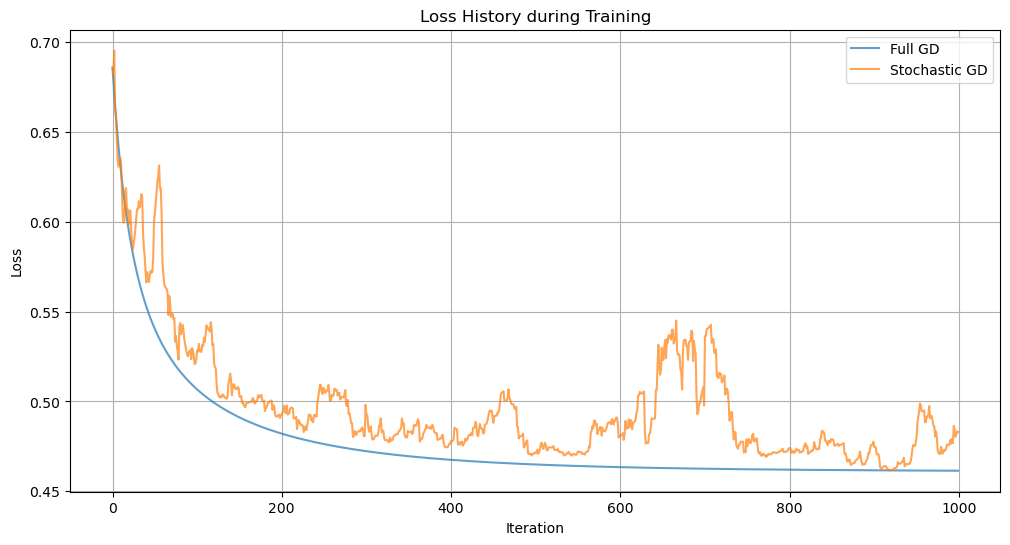

In [38]:
# your code
# Обучение модели с полным градиентным спуском
lr_full = MyLogisticRegression(gd_type='full', tolerance=1e-6, max_iter=1000, eta=1e-2)
lr_full.fit(X_train, y_train)

# Обучение модели со стохастическим градиентным спуском
lr_stochastic = MyLogisticRegression(gd_type='stochastic', tolerance=1e-6, max_iter=1000, eta=1e-2)
lr_stochastic.fit(X_train, y_train)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(lr_full.loss_history, label='Full GD', alpha=0.7)
plt.plot(lr_stochastic.loss_history, label='Stochastic GD', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss History during Training')
plt.legend()
plt.grid(True)
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

ROC-AUC (Full GD): 0.8588
ROC-AUC (Stochastic GD): 0.8495
PR-AUC (Full GD): 0.8211
PR-AUC (Stochastic GD): 0.7947


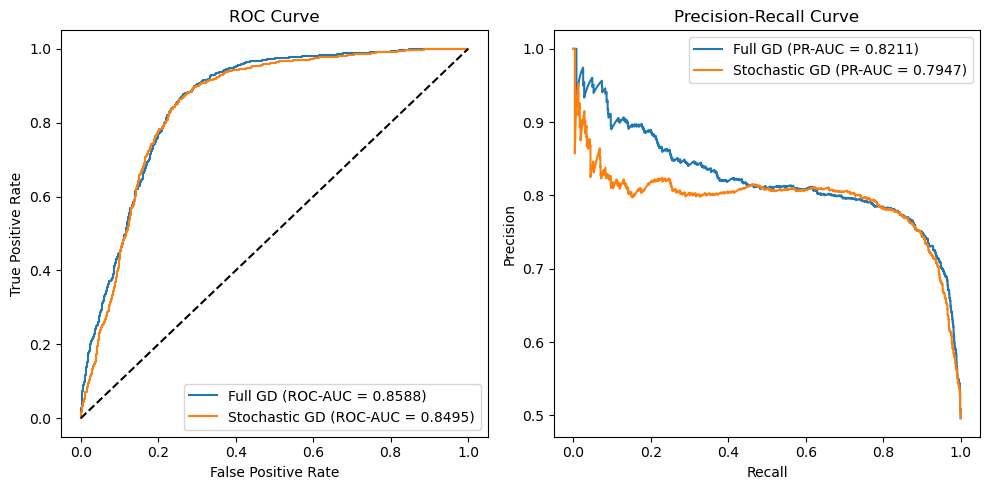

In [39]:
# your code
# Предсказания вероятностей на тестовой выборке
y_pred_proba_full = lr_full.predict_proba(X_test)[:, 1]
y_pred_proba_stochastic = lr_stochastic.predict_proba(X_test)[:, 1]

# Вычисление метрик
roc_auc_full = roc_auc_score(y_test, y_pred_proba_full)
roc_auc_stochastic = roc_auc_score(y_test, y_pred_proba_stochastic)

precision_full, recall_full, _ = precision_recall_curve(y_test, y_pred_proba_full)
pr_auc_full = auc(recall_full, precision_full)
precision_stochastic, recall_stochastic, _ = precision_recall_curve(y_test, y_pred_proba_stochastic)
pr_auc_stochastic = auc(recall_stochastic, precision_stochastic)

# Вывод метрик
print(f"ROC-AUC (Full GD): {roc_auc_full:.4f}")
print(f"ROC-AUC (Stochastic GD): {roc_auc_stochastic:.4f}")
print(f"PR-AUC (Full GD): {pr_auc_full:.4f}")
print(f"PR-AUC (Stochastic GD): {pr_auc_stochastic:.4f}")

# Построение ROC-кривых
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
fpr_full, tpr_full, _ = roc_curve(y_test, y_pred_proba_full)
fpr_stochastic, tpr_stochastic, _ = roc_curve(y_test, y_pred_proba_stochastic)
plt.plot(fpr_full, tpr_full, label=f"Full GD (ROC-AUC = {roc_auc_full:.4f})")
plt.plot(fpr_stochastic, tpr_stochastic, label=f"Stochastic GD (ROC-AUC = {roc_auc_stochastic:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Построение PR-кривых
plt.subplot(1, 2, 2)
plt.plot(recall_full, precision_full, label=f"Full GD (PR-AUC = {pr_auc_full:.4f})")
plt.plot(recall_stochastic, precision_stochastic, label=f"Stochastic GD (PR-AUC = {pr_auc_stochastic:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [40]:
# your code
# Настройка кросс-валидации
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = []
pr_auc_scores = []

for train_index, val_index in kfold.split(X, y):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    # Обучение модели
    model = MyLogisticRegression(gd_type='full', eta=0.1, max_iter=1000, tolerance=1e-6)
    model.fit(X_train_cv, y_train_cv)

    # Предсказания вероятностей для положительного класса
    y_probs = model.predict_proba(X_val_cv)[:, 1]

    # Вычисление метрик
    roc_auc = roc_auc_score(y_val_cv, y_probs)
    pr_auc = average_precision_score(y_val_cv, y_probs)

    roc_auc_scores.append(roc_auc)
    pr_auc_scores.append(pr_auc)

# Финальные оценки
print(f"ROC-AUC: mean={np.mean(roc_auc_scores):.4f}, std={np.std(roc_auc_scores):.4f}")
print(f"PR-AUC: mean={np.mean(pr_auc_scores):.4f}, std={np.std(pr_auc_scores):.4f}")


ROC-AUC: mean=0.8614, std=0.0088
PR-AUC: mean=0.8349, std=0.0135


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [41]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [42]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [43]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
#data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [44]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/zf/cg3sbbt500x0hs8pwdn7nmnm0000gn/T/ipykernel_1692/16828617.py:2: SyntaxWarning: invalid escape sequence '\s'
  raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)


In [45]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [46]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [47]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    # your code
    if len(R) == 0:
        return 0.0
    target_values = R['target']  # Последний столбец — целевая переменная
    mean = np.mean(target_values)
    variance = np.mean((target_values - mean) ** 2)
    return variance


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    # your code
    feature_idx = R_m.dtype.names.index(feature) if feature in R_m.dtype.names else -1
    if feature_idx == -1:
        raise ValueError(f"Feature {feature} not found in dataset")

    # Разделяем по порогу t
    R_l = R_m[R_m[feature] <= t]
    R_r = R_m[R_m[feature] > t]
    return R_l, R_r


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    # your code
    if len(R_m) == 0:
        return 0.0

    # Разбиваем вершину
    R_l, R_r = split_node(R_m, feature, t)

    # Вычисляем доли и информативность для левой и правой частей
    n_l = len(R_l)
    n_r = len(R_r)
    n_total = len(R_m)

    if n_total == 0:
        return 0.0

    h_l = H(R_l) if n_l > 0 else 0.0
    h_r = H(R_r) if n_r > 0 else 0.0

    # Критерий ошибки
    q = (n_l / n_total) * h_l + (n_r / n_total) * h_r
    return q


**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

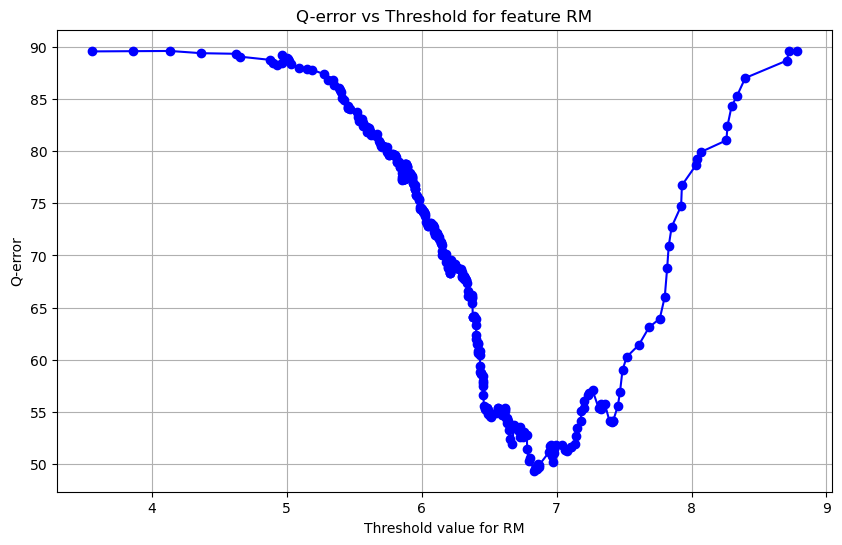

In [48]:
# your code
# Преобразуем X_train в numpy structured array
X_train_array = X_train.to_records(index=False)

feature_to_analyze = 'RM'  # Выбираем признак для анализа
thresholds = np.unique(X_train[feature_to_analyze])  # Уникальные значения как пороги
q_errors = []

for t in thresholds:
    error = q_error(X_train_array, feature_to_analyze, t)
    q_errors.append(error)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(thresholds, q_errors, marker='o', linestyle='-', color='b')
plt.xlabel(f"Threshold value for {feature_to_analyze}")
plt.ylabel("Q-error")
plt.title(f"Q-error vs Threshold for feature {feature_to_analyze}")
plt.grid(True)
plt.show()

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [49]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    # your code
    if len(R_m) == 0 or feature not in R_m.dtype.names:
        return 0.0, 0.0

    thresholds = np.unique(R_m[feature])  # Уникальные значения признака как пороги
    if len(thresholds) <= 1:
        return 0.0, q_error(R_m, feature, thresholds[0]) if len(thresholds) == 1 else 0.0

    min_q_error = float('inf')
    optimal_t = thresholds[0]

    for t in thresholds:
        error = q_error(R_m, feature, t)
        if error < min_q_error:
            min_q_error = error
            optimal_t = t

    return optimal_t, min_q_error

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

In [50]:
# your code
best_feature = None
best_threshold = 0.0
min_q_error_global = float('inf')

for feature in feature_names:
    optimal_t, min_q_error = get_optimal_split(X_train_array, feature)

    if min_q_error < min_q_error_global:
        min_q_error_global = min_q_error
        best_feature = feature
        best_threshold = optimal_t

print(f"Лучший признак: {best_feature}")
print(f"Оптимальный порог: {best_threshold:.4f}")
print(f"Минимальное значение: {min_q_error_global:.4f}")

Лучший признак: RM
Оптимальный порог: 6.8330
Минимальное значение: 49.3809


 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

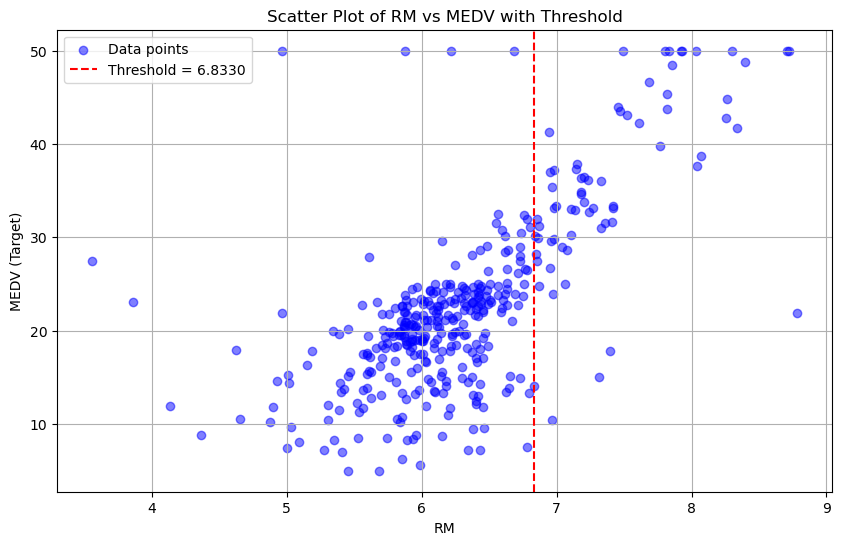

In [51]:
# your code
plt.figure(figsize=(10, 6))
plt.scatter(X_train[best_feature], X_train['target'], color='blue', alpha=0.5, label='Data points')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Threshold = {best_threshold:.4f}")
plt.xlabel(best_feature)
plt.ylabel('MEDV (Target)')
plt.title(f"Scatter Plot of {best_feature} vs MEDV with Threshold")
plt.legend()
plt.grid(True)
plt.show()
